# Decomposition of synthetic HDsEMG signals

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import emgkit
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import torch

logging.basicConfig(level=logging.INFO)  # 用于
# logging.basicConfig(level=logging.WARNING)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    DEVICE = torch.device("cpu")
    logging.info("Using CPU version")

SEED = 42
FS = 2000

INFO:root:Using CUDA version


(6, 20000)


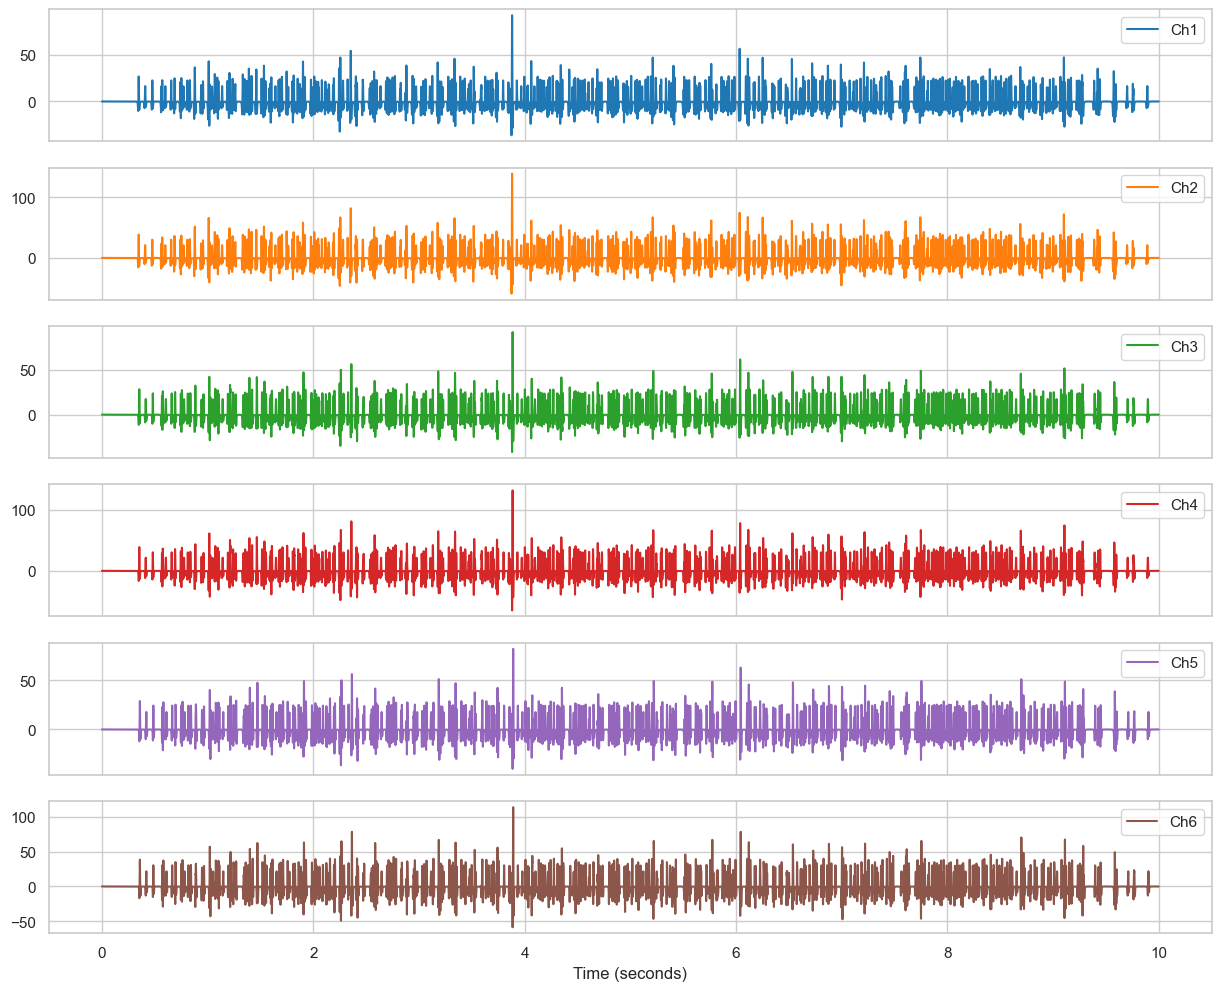

In [2]:
def load_data() -> np.ndarray:
    file_path = ".\\SimulationData\\sEMG_without_Noise_7MUs_3X2.mat"
    channel_array = scipy.io.loadmat(file_path)["output"] * 10**3
    return channel_array


SUBJECT_TYPE = "Simulation Data"

channel_array = load_data()
print(channel_array.shape)

# Visualize
emg_df = pd.DataFrame(
    {
        "Ch1": channel_array[0],
        "Ch2": channel_array[1],
        "Ch3": channel_array[2],
        "Ch4": channel_array[3],
        "Ch5": channel_array[4],
        "Ch6": channel_array[5],
    }
)

kwargs = {
    "title": f"Raw sEMG signal ({SUBJECT_TYPE})",
    "y_label": "Amplitude [\u03bcV]",
    "fig_size": (8, 14),
}
# plt.figure(figsize=(8, 19))
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 12)  # 设置默认图形大小
nk.signal_plot(emg_df, sampling_rate=FS, subplots=True)

## 直流偏移去除

In [3]:
# 遍历每个通道并计算均值和方差
for i, channel_data in enumerate(channel_array):
    channel_mean = np.mean(channel_data)
    channel_variance = np.var(channel_data)
    print(f"通道 {i+1} 的均值: {channel_mean:.5f}, 方差: {channel_variance:.5f}")
# 进行中心化处理
channel_array = channel_array - np.mean(channel_array, axis=1, keepdims=True)

通道 1 的均值: 0.00943, 方差: 94.29539
通道 2 的均值: 0.00943, 方差: 187.69409
通道 3 的均值: 0.00763, 方差: 101.05238
通道 4 的均值: 0.00764, 方差: 186.48058
通道 5 的均值: 0.00633, 方差: 103.13722
通道 6 的均值: 0.00622, 方差: 178.25113


## 信号频谱分析

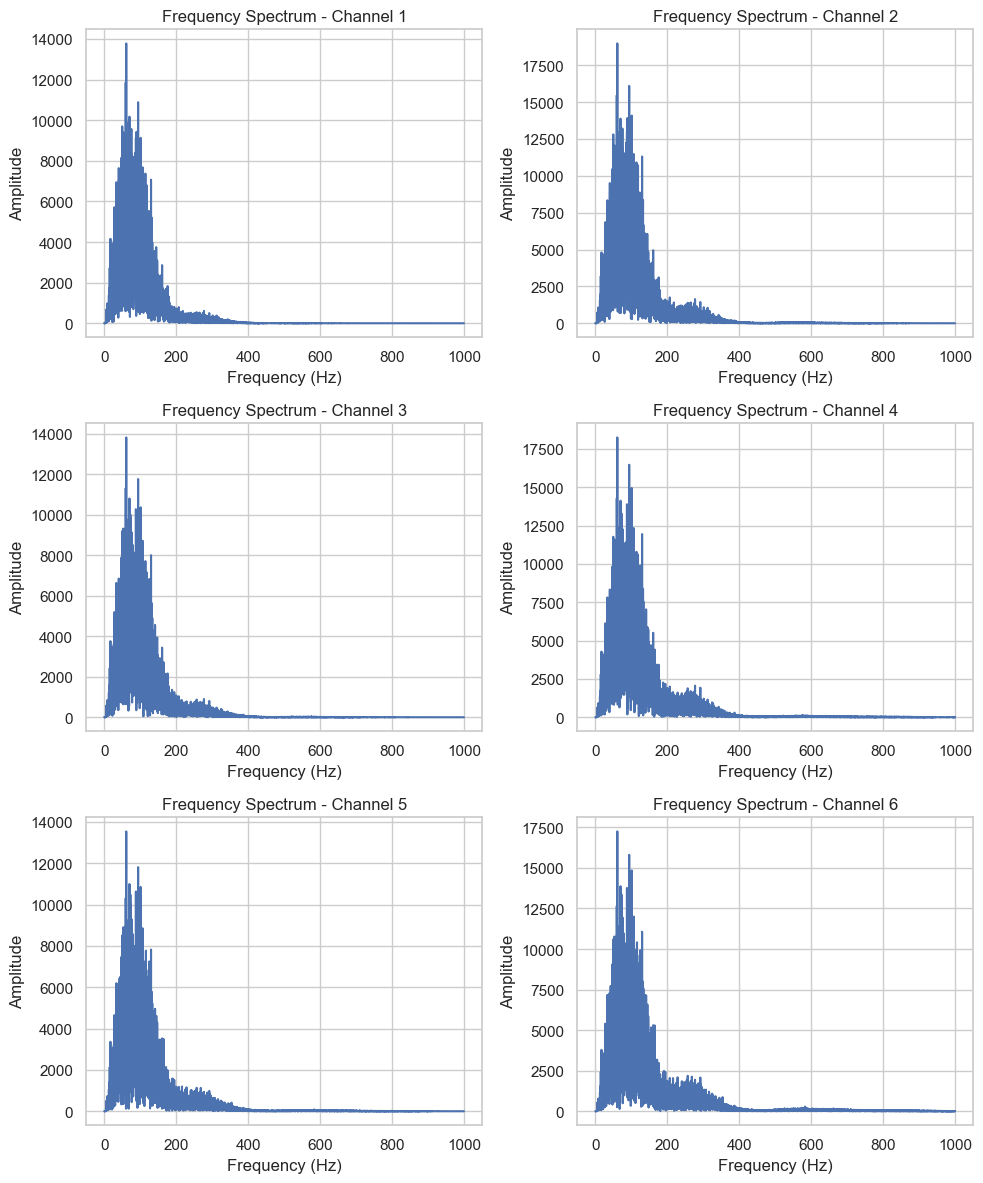

In [4]:
emgkit.preprocessing.plot_all_channels_frequency_spectrum(
    channel_array, fs=FS, figsize=(10, 4)
)

## 根据肌肉活动强度特征，自动提取活动区间段信息
（以后再完善优化该功能）

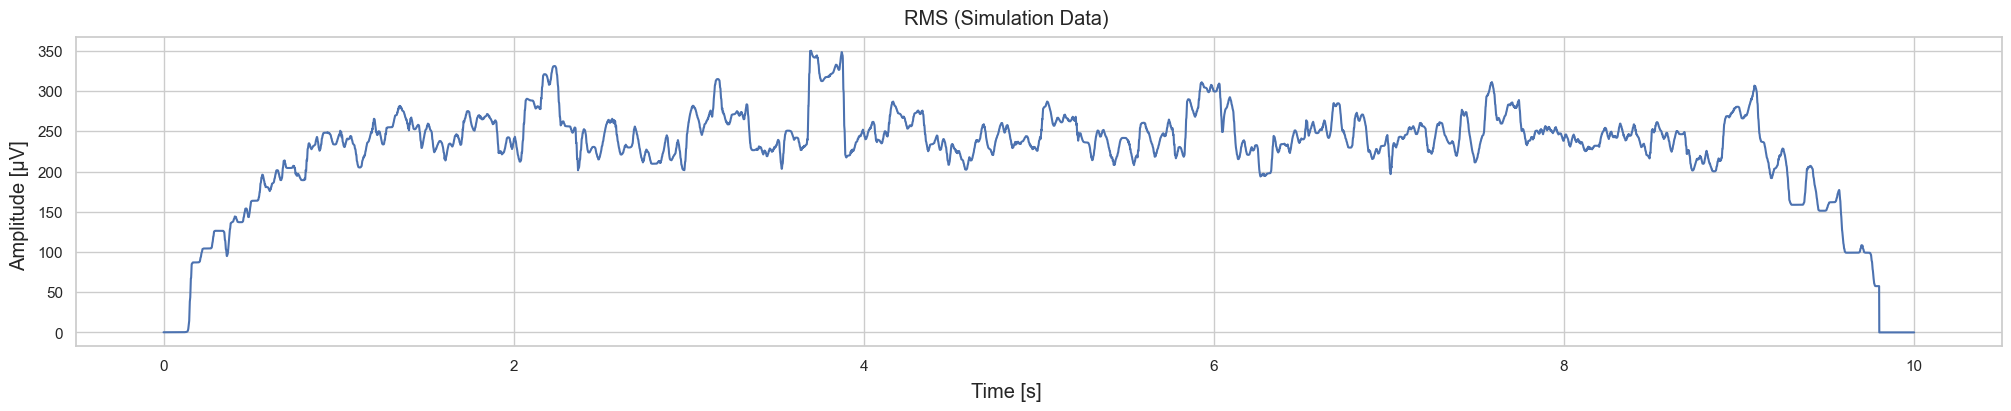

In [5]:
win_len = int(round(0.2 * FS))

emg_rms = np.zeros_like(channel_array)
for i in range(channel_array.shape[1] - win_len):
    cur_rms = (channel_array[:, i : i + win_len] ** 2).sum(axis=1)
    emg_rms[:, i] = np.sqrt(cur_rms)
emg_rms = np.mean(emg_rms, axis=0)

import numpy as np


def is_stable(signal_segment, stable_threshold):
    """Check if the signal segment is stable."""
    return np.var(signal_segment) < stable_threshold


def adjust_point(rms_signal, point, direction, stable_duration, stable_threshold):
    """
    Adjust the point backward or forward to find a stable region.
    direction should be -1 for backward search (start point),
    and 1 for forward search (end point).
    """
    while point > 0 and point < len(rms_signal):
        segment_start = max(0, point - stable_duration) if direction == -1 else point
        segment_end = (
            point if direction == -1 else min(len(rms_signal), point + stable_duration)
        )
        if is_stable(rms_signal[segment_start:segment_end], stable_threshold):
            break
        point += direction
    return point


def detect_stimulations(rms_signal, threshold_factor=0, min_duration=2, FS=2000):
    mean_val = np.mean(rms_signal)
    std_val = np.std(rms_signal)

    threshold = mean_val + threshold_factor * std_val

    stable_threshold = (
        std_val * 0.5
    )  # Define a lower variance threshold to assess stability. 0.05
    stable_duration = (
        FS // 4
    )  # Number of samples that signal needs to be stable for half a second.

    stim_starts = []
    stim_ends = []

    is_stimulating = False
    stim_start_pos = None

    for i, value in enumerate(rms_signal):
        if value > threshold and not is_stimulating:
            # Potential start of stimulation
            is_stimulating = True
            stim_start_pos = i

        elif value < threshold and is_stimulating:
            # Potential end of stimulation
            if i - stim_start_pos >= (min_duration * FS):
                # Adjust the end point to ensure it's stable after the stimulation
                adjusted_end = adjust_point(
                    rms_signal, i, 1, stable_duration, stable_threshold
                )
                # Adjust the start point to ensure it's stable before the stimulation
                adjusted_start = adjust_point(
                    rms_signal, stim_start_pos, -1, stable_duration, stable_threshold
                )

                # Only add the points if they are different from the initial ones
                if adjusted_end != i or adjusted_start != stim_start_pos:
                    stim_starts.append(adjusted_start / FS)
                    stim_ends.append(adjusted_end / FS)
            is_stimulating = False

    # Check if a stimulation was ongoing at the end of the signal
    if is_stimulating and len(rms_signal) - stim_start_pos >= (min_duration * FS):
        adjusted_end = adjust_point(
            rms_signal, len(rms_signal), 1, stable_duration, stable_threshold
        )
        adjusted_start = adjust_point(
            rms_signal, stim_start_pos, -1, stable_duration, stable_threshold
        )

        if adjusted_end != len(rms_signal) or adjusted_start != stim_start_pos:
            stim_starts.append(adjusted_start / FS)
            stim_ends.append(adjusted_end / FS)

    return stim_starts, stim_ends


stimulation_starts, stimulation_ends = detect_stimulations(emg_rms)
# 绘制RMS信号和刺激的开始/结束点

f, ax = plt.subplots(figsize=(20, 4), layout="constrained")
f.suptitle(f"RMS ({SUBJECT_TYPE})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03bcV]")

t = np.arange(channel_array.shape[1]) / FS
ax.plot(t, emg_rms)
# 在每个刺激的开始和结束点绘制垂直线
for start in stimulation_starts:
    ax.axvline(x=start, color="green", linestyle="--", linewidth=1, label="Start")
for end in stimulation_ends:
    ax.axvline(x=end, color="blue", linestyle="--", linewidth=1, label="End")
plt.show()

## Mannual Setting（先用人工设置肌肉活动区间段）

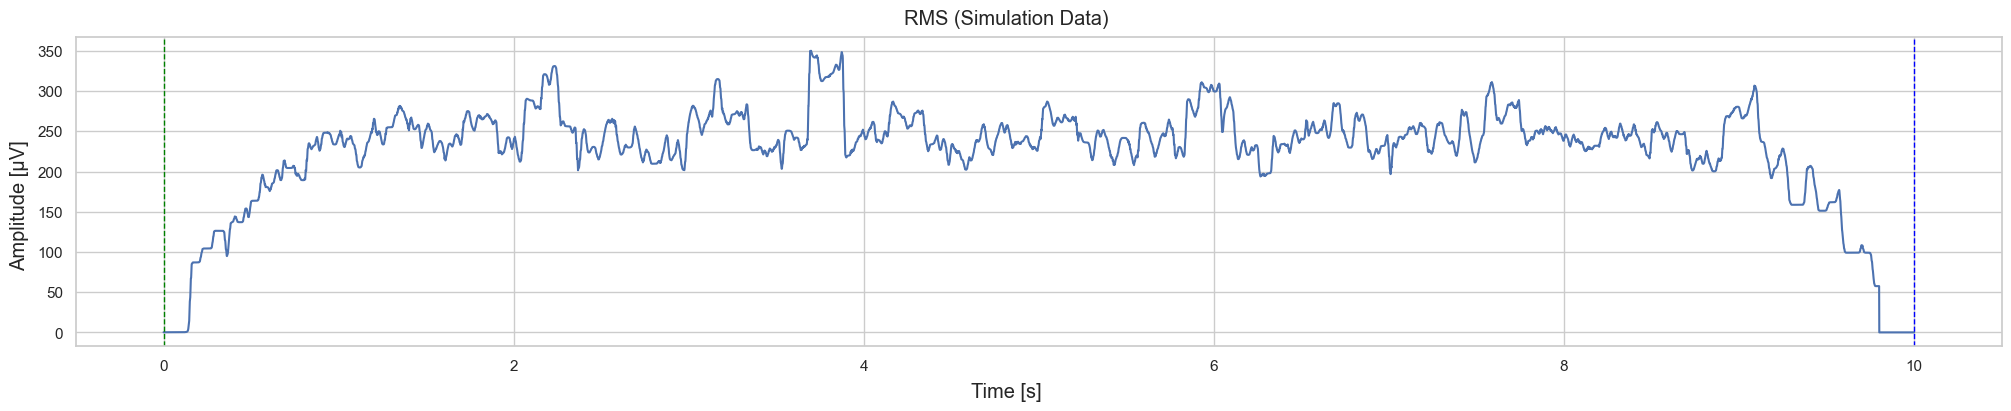

In [6]:
stimulation_starts = [0]
stimulation_ends = [10]
f, ax = plt.subplots(figsize=(20, 4), layout="constrained")
f.suptitle(f"RMS ({SUBJECT_TYPE})")
f.supxlabel("Time [s]")
f.supylabel("Amplitude [\u03bcV]")

t = np.arange(channel_array.shape[1]) / FS
ax.plot(t, emg_rms)
# 在每个刺激的开始和结束点绘制垂直线
for start in stimulation_starts:
    ax.axvline(x=start, color="green", linestyle="--", linewidth=1, label="Start")
for end in stimulation_ends:
    ax.axvline(x=end, color="blue", linestyle="--", linewidth=1, label="End")
plt.show()

## 人工选择信号质量较优的信号区间和通道

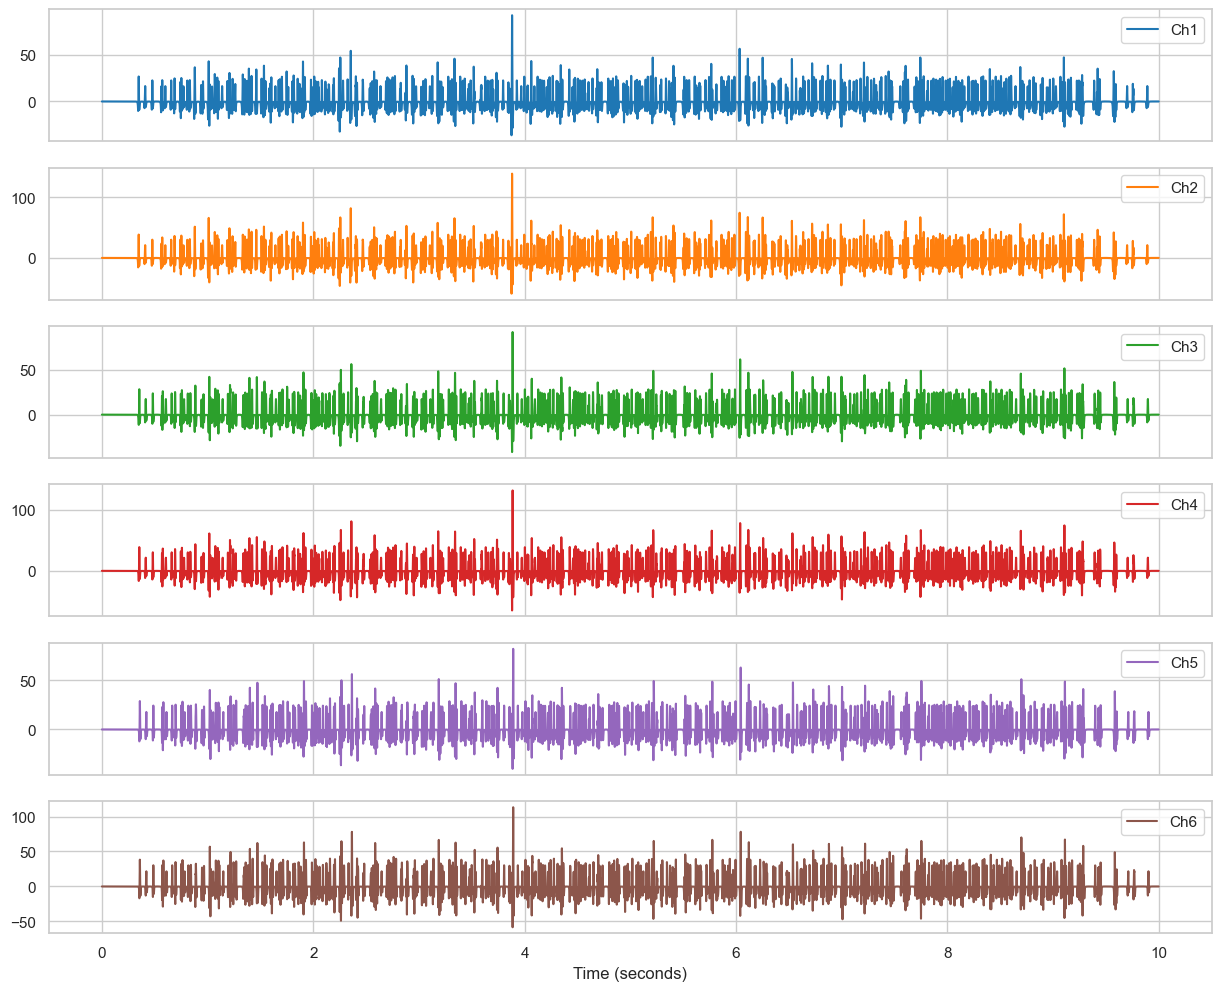

In [7]:
num_selected = 0
channel_array_removed_artifacts_backup = channel_array
channel_array_removed_artifacts = channel_array_removed_artifacts_backup[
    :,
    int(stimulation_starts[num_selected] * FS) : int(
        stimulation_ends[num_selected] * FS
    ),
]
emg_formal = pd.DataFrame(
    {
        "Ch1": channel_array[0],
        "Ch2": channel_array[1],
        "Ch3": channel_array[2],
        "Ch4": channel_array[3],
        "Ch5": channel_array[4],
        "Ch6": channel_array[5],
    }
)
emg_formal.shape
nk.signal_plot(emg_formal, sampling_rate=FS, subplots=True)

## 可视化仿真数据的发放序列

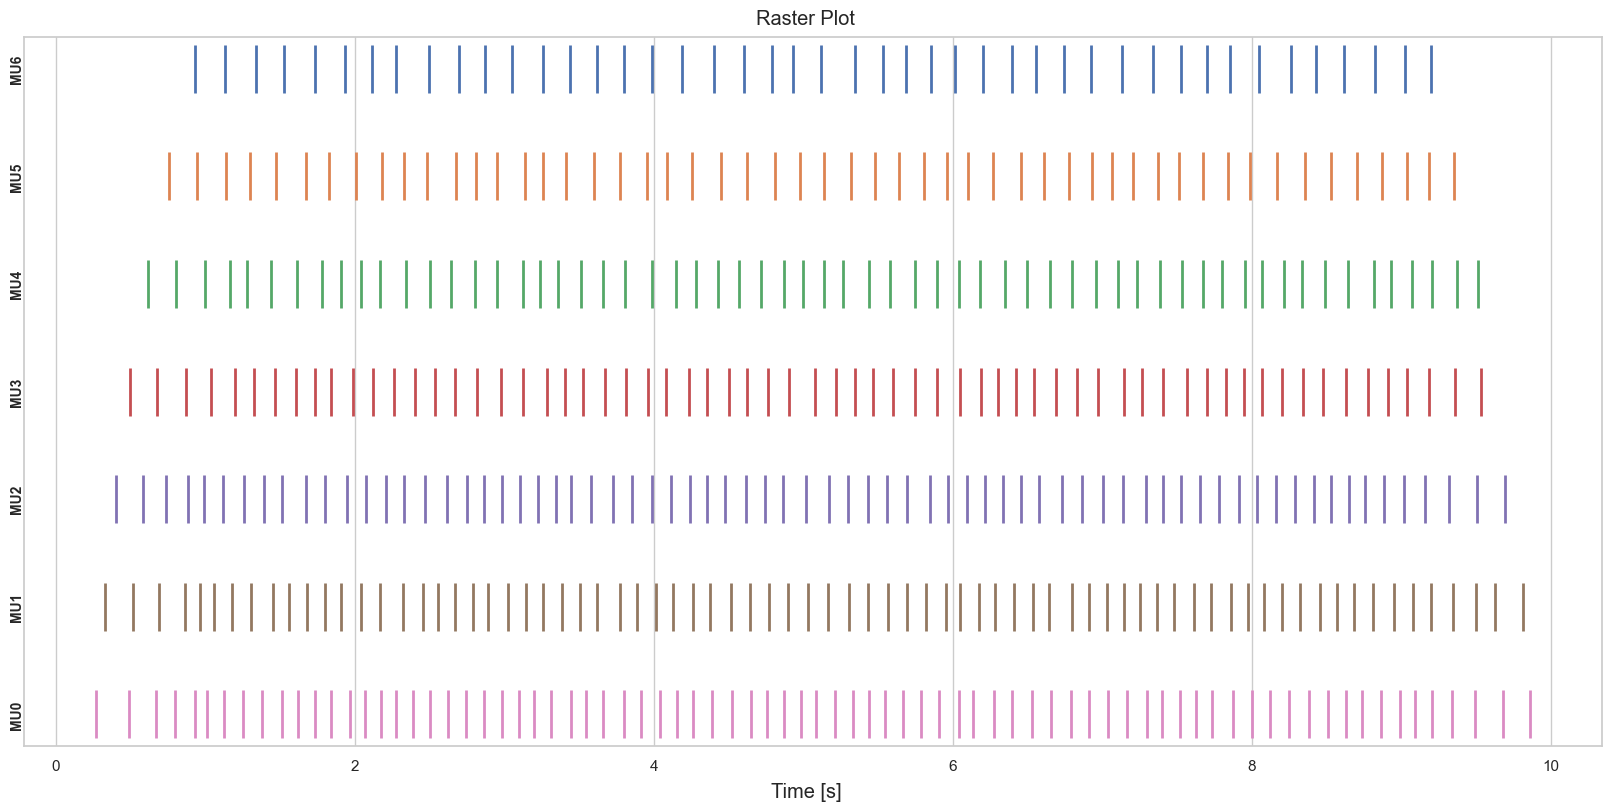

In [8]:
def adjust_to_min_unit(d, unit=0.0005, decimal_places=4):
    """
    Adjust all values in the dictionary so that they are multiples of the specified unit (default is 0.0005).
    Handles both scalar values and NumPy arrays. Rounds the output to the specified number of decimal places.

    Parameters:
    d (dict): The input dictionary with numerical values or NumPy arrays.
    unit (float): The unit to which the values will be adjusted. Default is 0.0005.
    decimal_places (int): Number of decimal places to round the final output to. Default is 4.

    Returns:
    dict: A new dictionary with adjusted values rounded to specified decimal places.
    """
    adjusted_dict = {}
    for k, v in d.items():
        if isinstance(v, np.ndarray):
            # For numpy arrays, apply rounding to each element
            adjusted_dict[k] = np.round(np.round(v / unit) * unit, decimal_places)
        else:
            # For scalar values, use normal rounding and then round to decimal_places
            adjusted_dict[k] = round(round(v / unit) * unit, decimal_places)
    return adjusted_dict


gt_path = ".\\SimulationData\\recrtuitment_model_7MUs_2000sf.mat"
gt = scipy.io.loadmat(gt_path)
gt = gt["RM"][0][0:7]

gt_spikes_t_tmp = {f"MU{i}": v for i, v in enumerate(gt)}
# 对字典的键进行排序，按照 MU 的编号大小排序
gt_spikes_t_tmp = {
    k: gt_spikes_t_tmp[k]
    for k in sorted(gt_spikes_t_tmp.keys(), key=lambda x: int(x[2:]), reverse=True)
}
gt_spikes_t = adjust_to_min_unit(gt_spikes_t_tmp, unit=0.0005)
emgkit.plotting.raster_plot(gt_spikes_t_tmp, fig_size=(16, 8))

## 解耦的发放序列与Ground Truth发放序列做对比

In [9]:
conv_bss = emgkit.decomposition.ConvBSS(
    fs=FS,
    f_ext=67,
    seed=SEED,
    device=torch.device("cuda:0"),
)
ics, spikes_t = conv_bss.decompose_training(emg_formal)
ext_sig_len_s = ics.shape[0] / FS
# 准备两个包含序列的数组
print(f"共分解出{len(spikes_t.keys())}个MU。")
# Get dense representation of spike trains
gt_spikes_bin = emgkit.utils.sparse_to_dense(gt_spikes_t, ext_sig_len_s, FS)
spikes_bin = emgkit.utils.sparse_to_dense(spikes_t, ext_sig_len_s, FS)
# Find mappings between valid MUs and ground-truth MUs
mu_mapping = []
for i in gt_spikes_t.keys():
    for j in spikes_t.keys():
        # A spike train is valid only if it shares at least 30% of firings with ground truth
        valid, _, tp, fp, fn = emgkit.utils.check_delayed_pair(
            gt_spikes_bin[i].to_numpy(),
            np.pad(
                spikes_bin[j].to_numpy(),
                pad_width=(gt_spikes_bin.shape[0] - spikes_bin.shape[0], 0),
            ),
            fs=FS,
            tol_ms=0.5,
            min_perc=0.3,
        )
        # print(valid, tp, fp, fn)
        if valid:
            # Compute metrics
            roa = tp / (tp + fn + fp)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            mu_mapping.append((i, j, roa, precision, recall))
# Sort by RoA
mu_mapping = sorted(mu_mapping, key=lambda t: t[3])
# Keep unique pairs with highest RoA
valid_mus = {}
identified_mus = {}
while len(mu_mapping) != 0:
    # Pop last pair (i.e., the one with the highest RoA
    gt_mu, val_mu, roa, precision, recall = mu_mapping.pop()
    # If valid MU and ground-truth MU are not paired yet, save association
    if gt_mu not in identified_mus.keys() and val_mu not in valid_mus.keys():
        identified_mus[gt_mu] = val_mu
        valid_mus[val_mu] = (gt_mu, roa, precision, recall)
cur_valid_n_mu = len(valid_mus.keys())
cur_tot_n_mu = len(spikes_t.keys())
print(f"Extracted {cur_valid_n_mu} valid MUs out of {cur_tot_n_mu} detected.")
cur_roa_list = []
cur_precision_list = []
cur_recall_list = []
for est_mu, (gt_mu, roa, precision, recall) in valid_mus.items():
    print(f"Estimated {est_mu} <-> ground truth {gt_mu}")
    print(f"\tRoA: {roa:.2%}\tPrecision: {precision:.2%}\t Recall: {recall:.2%}")
    cur_roa_list.append(roa)
    cur_precision_list.append(precision)
    cur_recall_list.append(recall)
cur_roa_avg = np.mean(cur_roa_list)
cur_roa_std = np.std(cur_roa_list)
cur_precision_avg = np.mean(cur_precision_list)
cur_precision_std = np.std(cur_precision_list)
cur_recall_avg = np.mean(cur_recall_list)
cur_recall_std = np.std(cur_recall_list)
print(f"Average RoA: {cur_roa_avg:.2f} ± {cur_roa_std:.2f}")
print(f"Average precision: {cur_precision_avg:.2f} ± {cur_precision_std:.2f}")
print(f"Average recall: {cur_recall_avg:.2f} ± {cur_recall_std:.2f}")

INFO:root:Number of channels before extension: 6
INFO:root:Number of channels after extension: 402
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 66 iterations, the distance is: 9.404e-05.
INFO:root:CoV-ISI increased from 10.05% to 10.05% after 1 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 52 iterations, the distance is: 6.439e-05.
INFO:root:CoV-ISI increased from 10.05% to 10.05% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 18 iterations, the distance is: 5.773e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 22 iterations, the distance is: 6.716e-05.
INFO:root:CoV-ISI increased from 45.92% to 45.92% after 1 steps.
INFO:root:----- IC 5 -----
INFO:root:FastICA converged after 41 iterations, the distance is: 9.296e-05.
INFO:root:CoV-ISI increased from 10.05% to 10.05% after 1 steps.
INFO:root:----- IC 6 -----
INFO:root:FastICA converged a

共分解出7个MU。
Extracted 7 valid MUs out of 7 detected.
Estimated MU2 <-> ground truth MU6
	RoA: 100.00%	Precision: 100.00%	 Recall: 100.00%
Estimated MU1 <-> ground truth MU0
	RoA: 84.71%	Precision: 92.31%	 Recall: 91.14%
Estimated MU3 <-> ground truth MU3
	RoA: 85.71%	Precision: 92.31%	 Recall: 92.31%
Estimated MU4 <-> ground truth MU1
	RoA: 80.95%	Precision: 89.47%	 Recall: 89.47%
Estimated MU5 <-> ground truth MU2
	RoA: 79.75%	Precision: 88.73%	 Recall: 88.73%
Estimated MU6 <-> ground truth MU5
	RoA: 79.66%	Precision: 88.68%	 Recall: 88.68%
Estimated MU0 <-> ground truth MU4
	RoA: 74.29%	Precision: 85.25%	 Recall: 85.25%
Average RoA: 0.84 ± 0.08
Average precision: 0.91 ± 0.04
Average recall: 0.91 ± 0.04


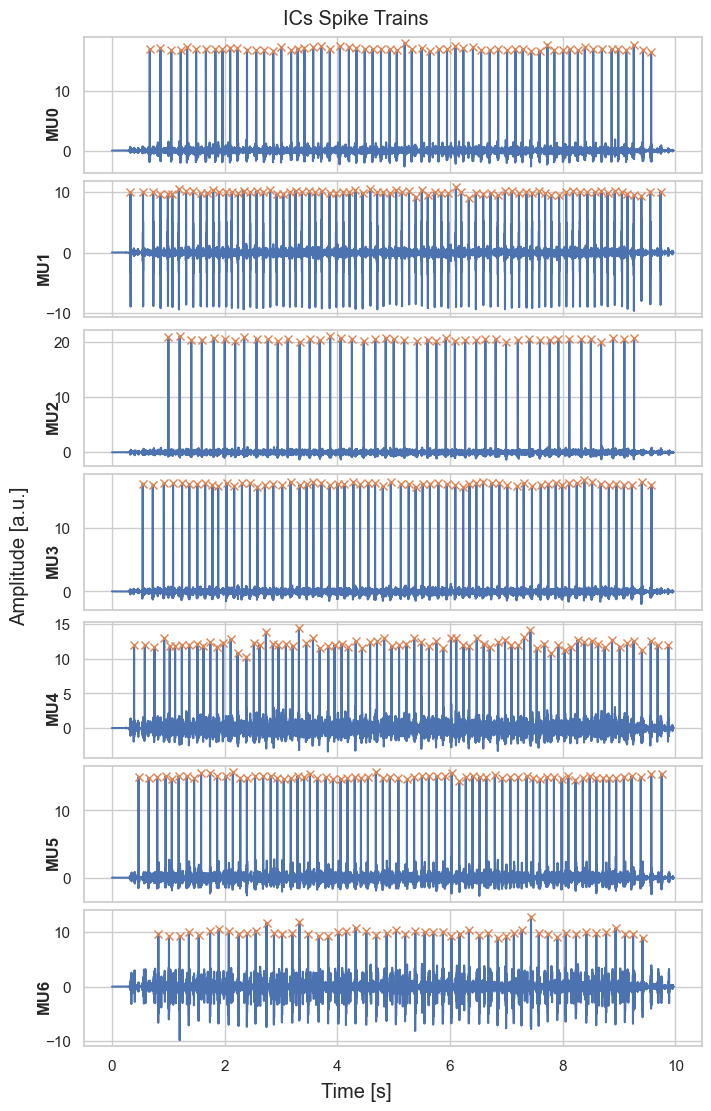

In [10]:
emgkit.plotting.plot_ic_spikes(ics, spikes_t, fig_size=(7, 11))

Display the raster plot.

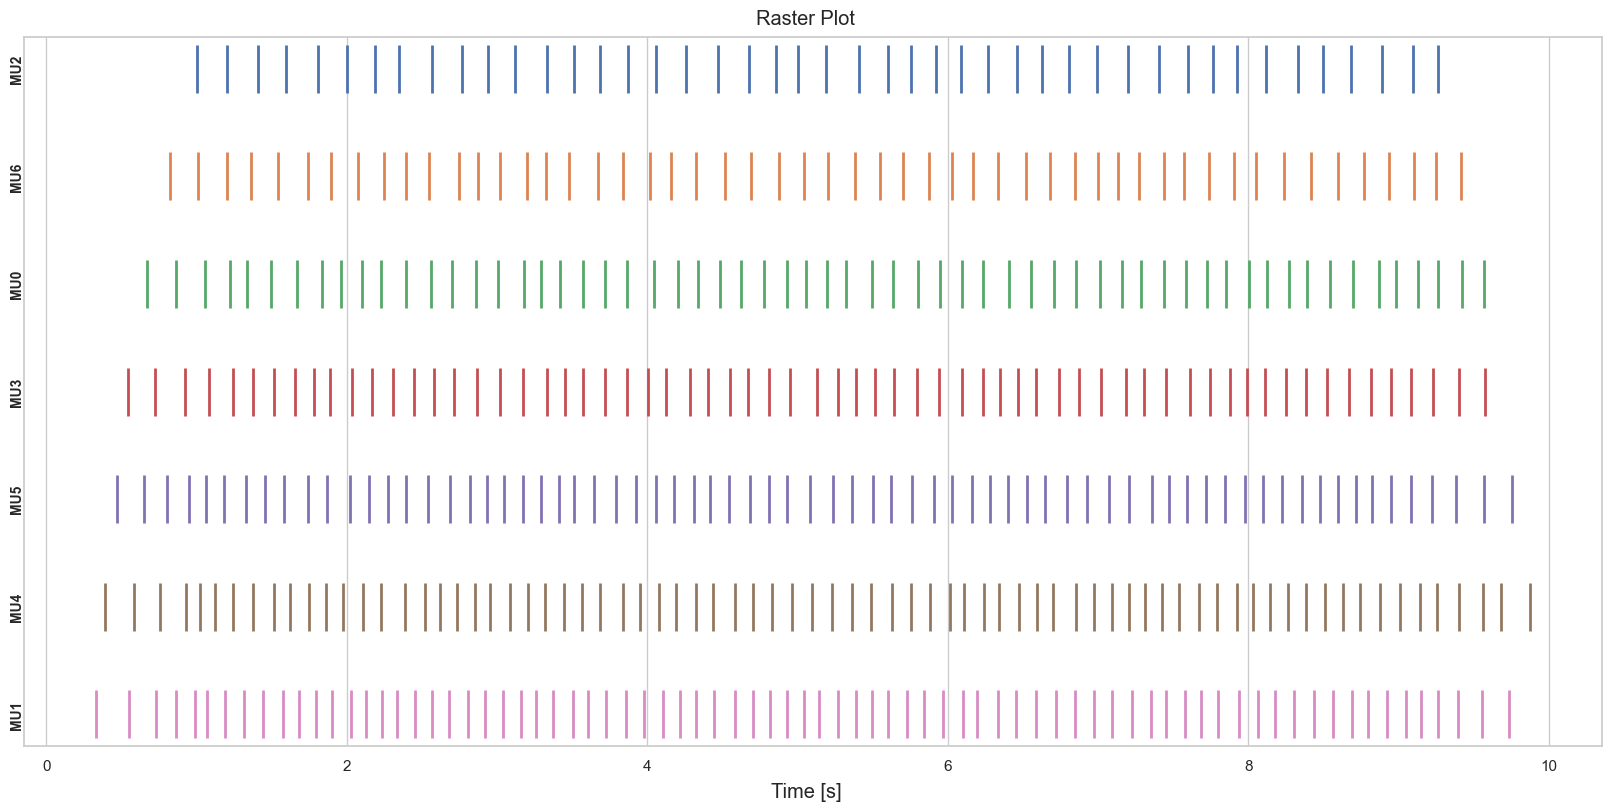

In [11]:
# 1. 获取 gt_spikes_t_tmp 中的 ground truth MU 的顺序
gt_order = list(
    gt_spikes_t_tmp.keys()
)  # ['MU0', 'MU1', 'MU2', 'MU3', 'MU4', 'MU5', 'MU6']

# 2. 创建一个新的字典，按 ground truth MU 的顺序重新排列 spikes_t
aligned_spikes_t = {}

# 遍历 gt_order，找到与其对应的 Estimated MU
for gt_mu in gt_order:
    # 根据 valid_mus 中的 ground truth MU 找到对应的 Estimated MU
    for est_mu, (mapped_gt_mu, _, _, _) in valid_mus.items():
        if mapped_gt_mu == gt_mu:
            # 将 Estimated MU 的 spike 数据按照 ground truth MU 的顺序进行排列
            aligned_spikes_t[est_mu] = spikes_t[est_mu]
            break
emgkit.plotting.raster_plot(aligned_spikes_t, fig_size=(16, 8))

Display the discharge rate.

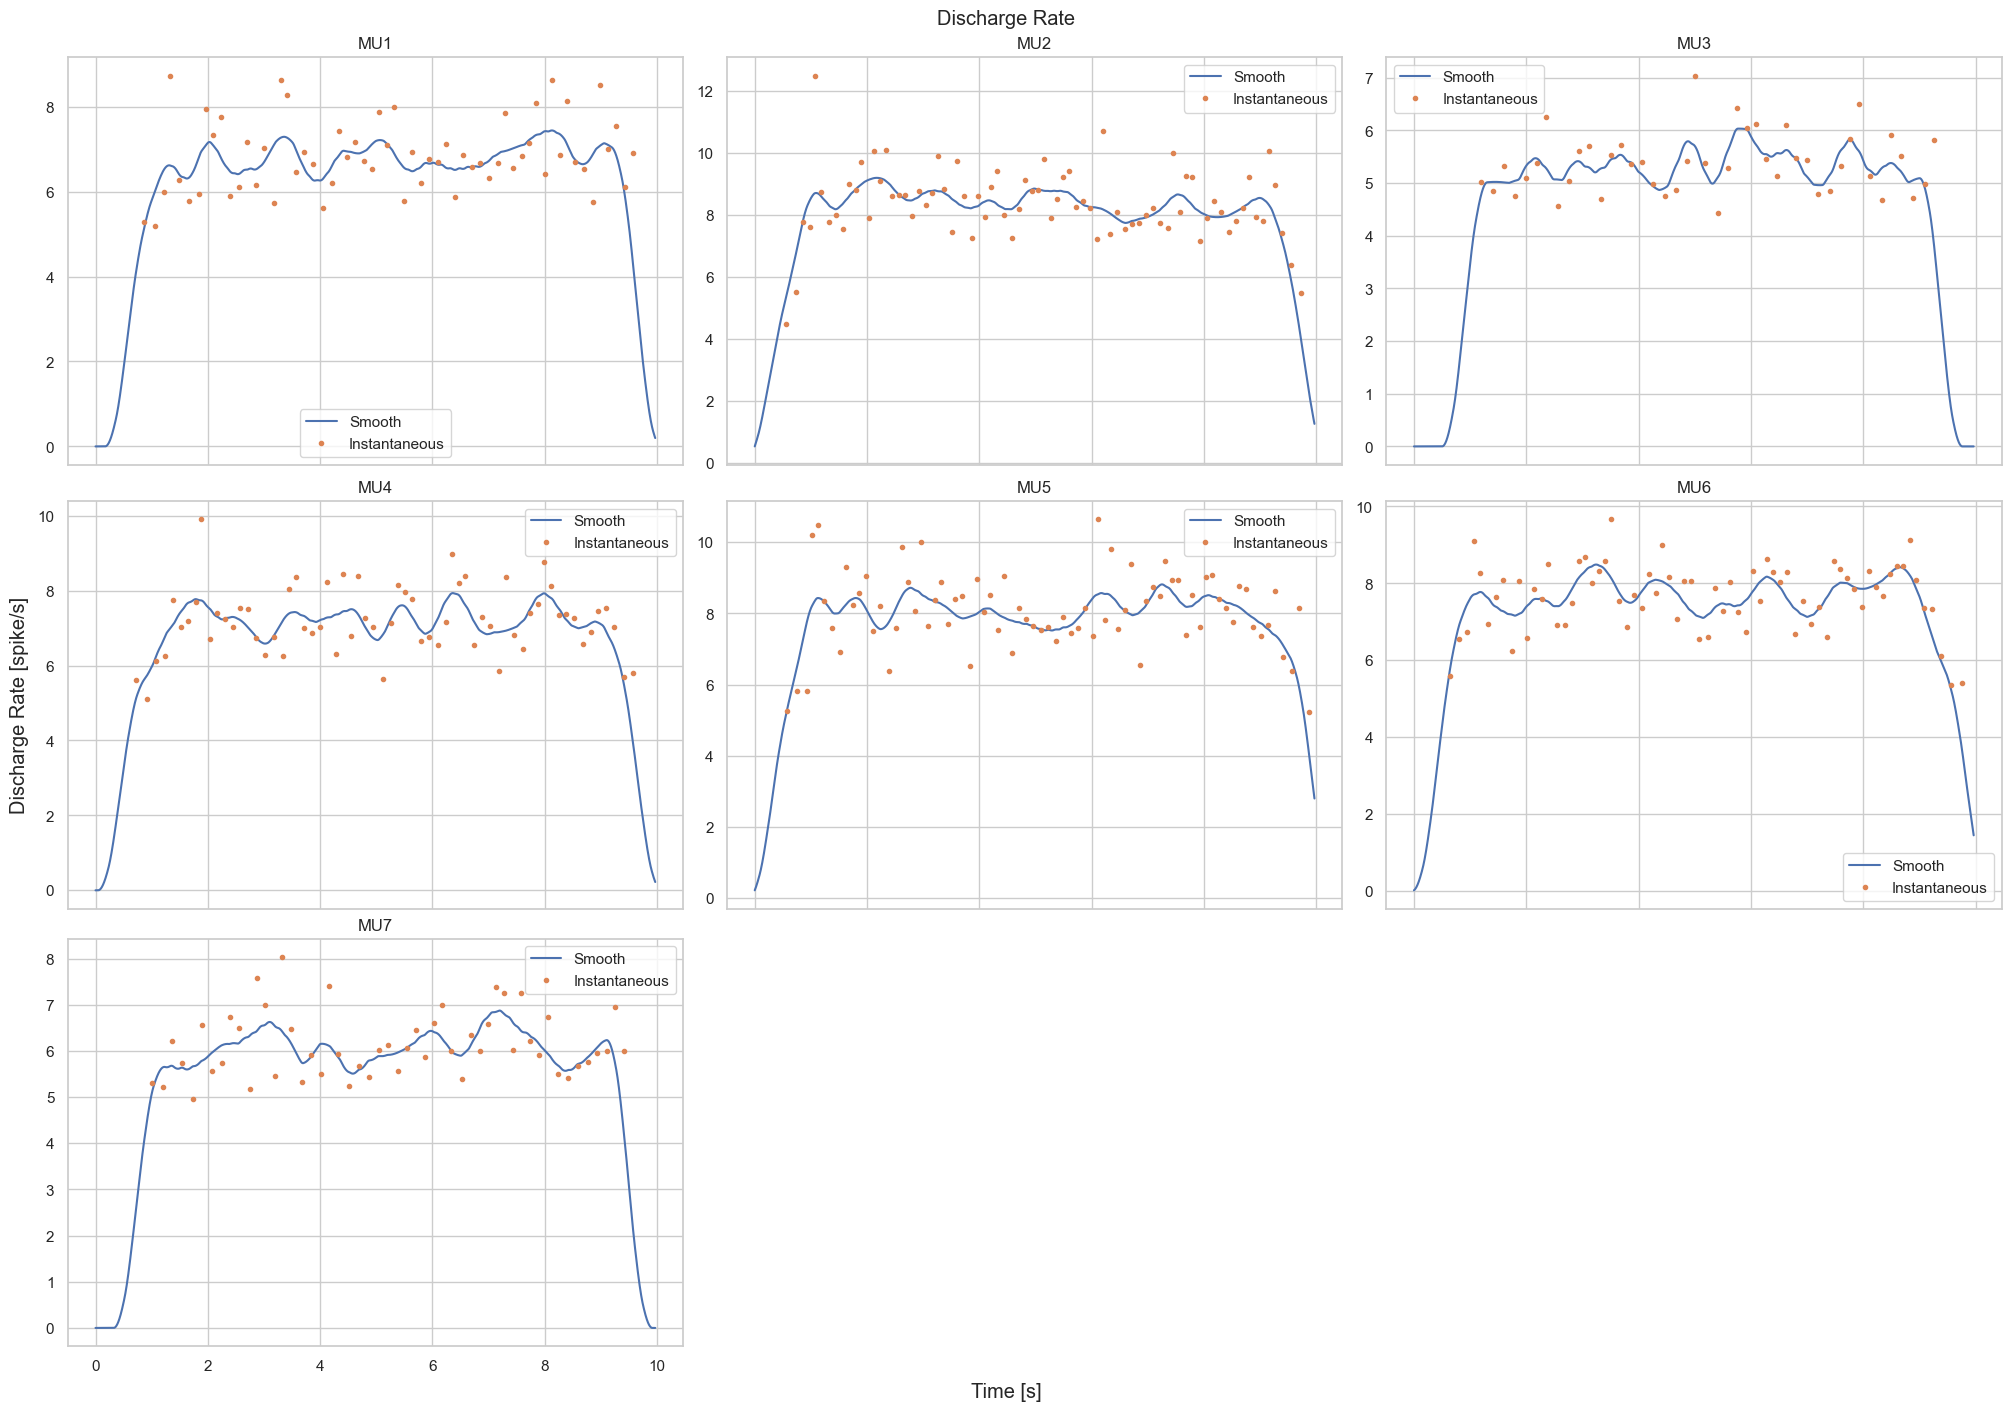

In [12]:
emgkit.plotting.plot_discharges(spikes_t, ext_sig_len_s, FS, fig_size=(20, 14))

Compute the waveforms and plot them.

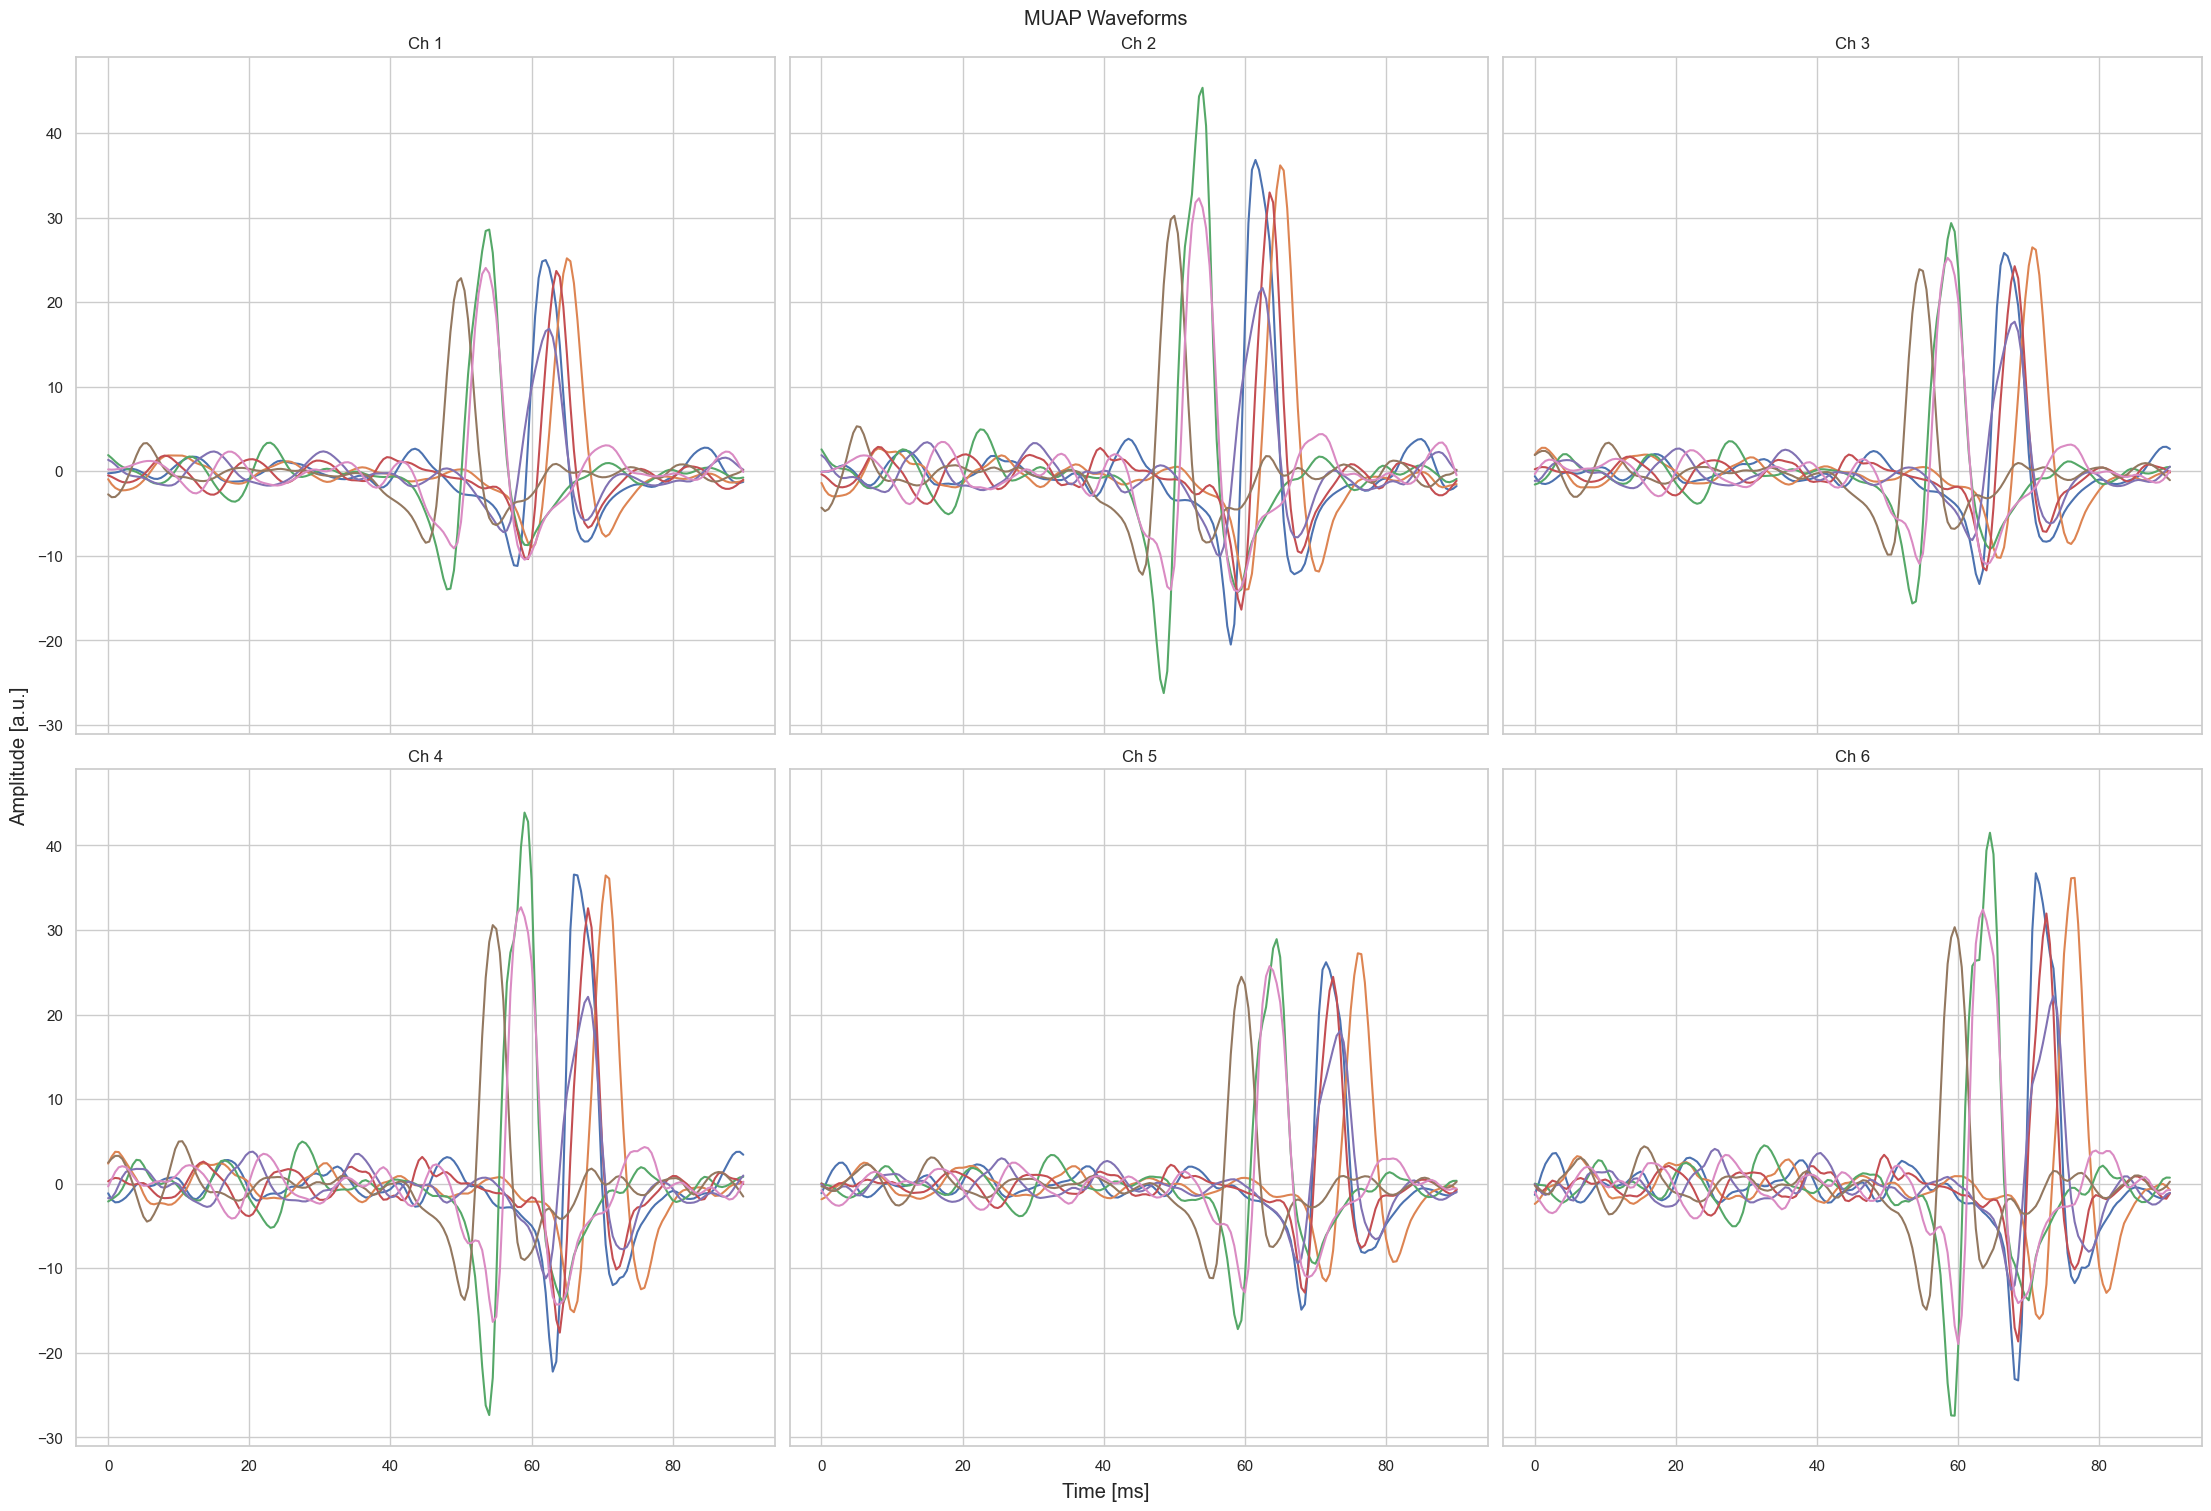

In [13]:
wfs = emgkit.utils.compute_waveforms(emg_formal, spikes_t, wf_radius_ms=45.0, fs=FS)
emgkit.plotting.plot_waveforms(wfs, fs=FS, n_cols=3, fig_size=(22, 15))

Compare the extracted MUs with the ground truth.

In [14]:
import numpy as np


def multi_unit_pnr(ics, peak_indices, method="mean"):
    """
    计算多个通道（MU0, MU1, MU2, ...）的总体PNR。

    Parameters
    ----------
    ics: pandas.DataFrame
        每个通道的信号 DataFrame，列为通道名称（如 'MU0', 'MU1', ...），行表示通道信号平方值。
    peak_indices: pandas.DataFrame
        每个通道的二值化峰值索引 DataFrame，形状与ics相同，1表示峰值位置，0表示非峰值位置。
    method: str, optional
        合并多通道PNR的方法，'mean' 表示算术平均，'max' 表示取最大值，'min' 表示取最小值。

    Returns
    -------
    float
        总体PNR值。
    """

    def pnr(s_i, peak_mask, epsilon=1e-10):
        """
        计算Pulse-to-Noise Ratio (PNR)。

        Parameters
        ----------
        s_i : numpy.ndarray
            输入的信号样本。
        peak_mask : numpy.ndarray
            二值化的峰值掩码，1表示峰值，0表示非峰值。
        epsilon : float, optional
            防止除零的小值偏移量，默认值为1e-10。

        Returns
        -------
        float
            计算得到的PNR值。
        """

        # 找到峰值位置（peak_mask 为 1 的位置），并计算平方后的均值
        signal_power = np.mean(s_i[peak_mask == 1] ** 2)

        # 找到噪声位置（peak_mask 为 0 的位置），并计算平方后的均值
        noise_power = np.mean(s_i[peak_mask == 0] ** 2)

        # 防止噪声功率为0，使用epsilon避免log10(0)
        if noise_power == 0:
            return np.inf  # 如果噪声功率为0，返回无穷大的PNR

        # 计算信号和噪声的对数，并返回PNR
        signal_db = 10 * np.log10(signal_power + epsilon)
        noise_db = 10 * np.log10(noise_power + epsilon)

        return signal_db - noise_db

    # 存储每个通道的PNR值
    pnr_values = []

    # 遍历每个通道（列）
    for column in ics.columns:
        s_i = ics[column]  # 取出每个通道的信号
        peak_mask = peak_indices[column]  # 取出通道的二值化峰值索引
        # 计算该通道的 PNR
        pnr_value = pnr(s_i.copy(), peak_mask.copy())  # 使用副本，避免修改原数据
        pnr_values.append(pnr_value)

    pnr_values = np.array(pnr_values)

    # 根据指定的方法合并PNR值
    if method == "mean":
        return pnr_values.mean()
    elif method == "max":
        return pnr_values.max()
    elif method == "min":
        return pnr_values.min()
    else:
        raise ValueError("method参数只能为 'mean', 'max', 或 'min'")


print(
    f"PNR: {multi_unit_pnr(ics, emgkit.utils.sparse_to_dense(spikes_t, ext_sig_len_s, FS))}"
)

PNR: 29.727360727679887


In [15]:
# # 遍历 f_ext 从 5 到 50
# for f_ext in range(1, 500):
#     spikes_keys_count = []

#     # 对每个 f_ext 运行 20 次
#     for _ in range(1):
#         # 随机生成种子
#         # SEED = random.randint(0, 9999)
#         # 创建 ConvBSS 实例
#         conv_bss1 = emgkit.decomposition.ConvBSS(
#             fs=FS,
#             f_ext=f_ext,
#             seed=SEED,
#             device=torch.device("cuda:0"),
#         )
#         conv_bss2 = emgkit.decomposition.ConvBSS(
#             fs=FS,
#             f_ext=f_ext,
#             seed=SEED,
#             device=torch.device("cuda:0"),
#         )

#         # 初始化 ics 和 spikes_t
#         ics = None
#         spikes_t = {}

#         ics_1, spikes_t_1 = conv_bss1.decompose_training(emg_batch1)
#         ics_2, spikes_t_2 = conv_bss2.decompose_training(emg_batch2)
#         # 记录 spikes_t.keys() 的长度
#         spikes_keys_count.append(len(spikes_t.keys()))
#         if len(spikes_t_1.keys()) == len(spikes_t_2.keys()):
#             print(f"f_ext = {f_ext}------{len(spikes_t_1.keys())}")

## 稳定性验证

In [16]:
emg_batch1 = pd.DataFrame(
    {
        "Ch1": channel_array[0],
        "Ch2": channel_array[2],
        "Ch3": channel_array[4],
    }
)
conv_bss1 = emgkit.decomposition.ConvBSS(
    fs=FS,
    f_ext=57,
    seed=SEED,
    device=torch.device("cuda:0"),
)
ics1, spikes_t1 = conv_bss1.decompose_training(emg_batch1)
ext_sig_len_s1 = ics1.shape[0] / FS
# 准备两个包含序列的数组
print(f"Patch 1 共分解出{len(spikes_t1.keys())}个MU。")


emg_batch2 = pd.DataFrame(
    {
        "Ch1": channel_array[1],
        "Ch2": channel_array[3],
        "Ch3": channel_array[5],
    }
)
conv_bss2 = emgkit.decomposition.ConvBSS(
    fs=FS,
    f_ext=57,
    seed=SEED,
    device=torch.device("cuda:0"),
)
# ics2, spikes_t2 = conv_bss1.decompose_inference(emg_batch2)
ics2, spikes_t2 = conv_bss2.decompose_training(emg_batch2)
ext_sig_len_s2 = ics2.shape[0] / FS
# 准备两个包含序列的数组
print(f"Patch 2 共分解出{len(spikes_t2.keys())}个MU。")

INFO:root:Number of channels before extension: 3
INFO:root:Number of channels after extension: 171
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 59 iterations, the distance is: 9.648e-05.
INFO:root:CoV-ISI decreased from 12.66% to 12.60% after 1 steps.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 2 steps.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 55 iterations, the distance is: 9.508e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 73 iterations, the distance is: 8.833e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 35 iterations, the distance is: 9.828e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 5 -----
INFO:root:FastICA converged after 70 iterations, the distance is: 8.903e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 

Patch 1 共分解出4个MU。


INFO:root:----- IC 5 -----
INFO:root:FastICA converged after 54 iterations, the distance is: 8.930e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 6 -----
INFO:root:FastICA converged after 59 iterations, the distance is: 9.271e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 steps.
INFO:root:----- IC 7 -----
INFO:root:FastICA converged after 55 iterations, the distance is: 9.357e-05.
INFO:root:CoV-ISI decreased from 15.17% to 10.05% after 1 steps.
INFO:root:CoV-ISI increased from 10.05% to 10.05% after 2 steps.
INFO:root:----- IC 8 -----
INFO:root:FastICA converged after 31 iterations, the distance is: 9.812e-05.
INFO:root:CoV-ISI increased from 51.58% to 52.55% after 1 steps.
INFO:root:----- IC 9 -----
INFO:root:CoV-ISI increased from 10.05% to 10.05% after 1 steps.
INFO:root:----- IC 10 -----
INFO:root:FastICA converged after 43 iterations, the distance is: 9.963e-05.
INFO:root:CoV-ISI increased from 12.60% to 12.60% after 1 step

Patch 2 共分解出4个MU。


In [17]:
# Get dense representation of spike trains
gt_spikes_bin = emgkit.utils.sparse_to_dense(spikes_t1, ext_sig_len_s1, FS)
spikes_bin = emgkit.utils.sparse_to_dense(spikes_t2, ext_sig_len_s2, FS)
# Find mappings between valid MUs and ground-truth MUs
mu_mapping = []
for i in spikes_t1.keys():
    for j in spikes_t2.keys():
        # A spike train is valid only if it shares at least 30% of firings with ground truth
        valid, _, tp, fp, fn = emgkit.utils.check_delayed_pair(
            gt_spikes_bin[i].to_numpy(),
            np.pad(
                spikes_bin[j].to_numpy(),
                pad_width=(gt_spikes_bin.shape[0] - spikes_bin.shape[0], 0),
            ),
            fs=FS,
            tol_ms=0.5,
            min_perc=0.3,
        )
        # print(valid, tp, fp, fn)
        if valid:
            # Compute metrics
            roa = tp / (tp + fn + fp)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            mu_mapping.append((i, j, roa, precision, recall))
# Sort by RoA
mu_mapping = sorted(mu_mapping, key=lambda t: t[3])
# Keep unique pairs with highest RoA
valid_mus = {}
identified_mus = {}
while len(mu_mapping) != 0:
    # Pop last pair (i.e., the one with the highest RoA
    gt_mu, val_mu, roa, precision, recall = mu_mapping.pop()
    # If valid MU and ground-truth MU are not paired yet, save association
    if gt_mu not in identified_mus.keys() and val_mu not in valid_mus.keys():
        identified_mus[gt_mu] = val_mu
        valid_mus[val_mu] = (gt_mu, roa, precision, recall)
cur_valid_n_mu = len(valid_mus.keys())
cur_tot_n_mu = len(spikes_t1.keys())
print(f"Extracted {cur_valid_n_mu} valid MUs out of {cur_tot_n_mu} detected.")
cur_roa_list = []
cur_precision_list = []
cur_recall_list = []
for est_mu, (gt_mu, roa, precision, recall) in valid_mus.items():
    print(f"Estimated {est_mu} <-> ground truth {gt_mu}")
    print(f"\tRoA: {roa:.2%}")
    cur_roa_list.append(roa)
    cur_precision_list.append(precision)
    cur_recall_list.append(recall)
cur_roa_avg = np.mean(cur_roa_list)
cur_roa_std = np.std(cur_roa_list)
cur_precision_avg = np.mean(cur_precision_list)
cur_precision_std = np.std(cur_precision_list)
cur_recall_avg = np.mean(cur_recall_list)
cur_recall_std = np.std(cur_recall_list)
print(f"Average RoA: {cur_roa_avg:.2f} ± {cur_roa_std:.2f}")

Extracted 4 valid MUs out of 4 detected.
Estimated MU2 <-> ground truth MU3
	RoA: 100.00%
Estimated MU1 <-> ground truth MU1
	RoA: 100.00%
Estimated MU0 <-> ground truth MU0
	RoA: 100.00%
Estimated MU3 <-> ground truth MU2
	RoA: 69.44%
Average RoA: 0.92 ± 0.13


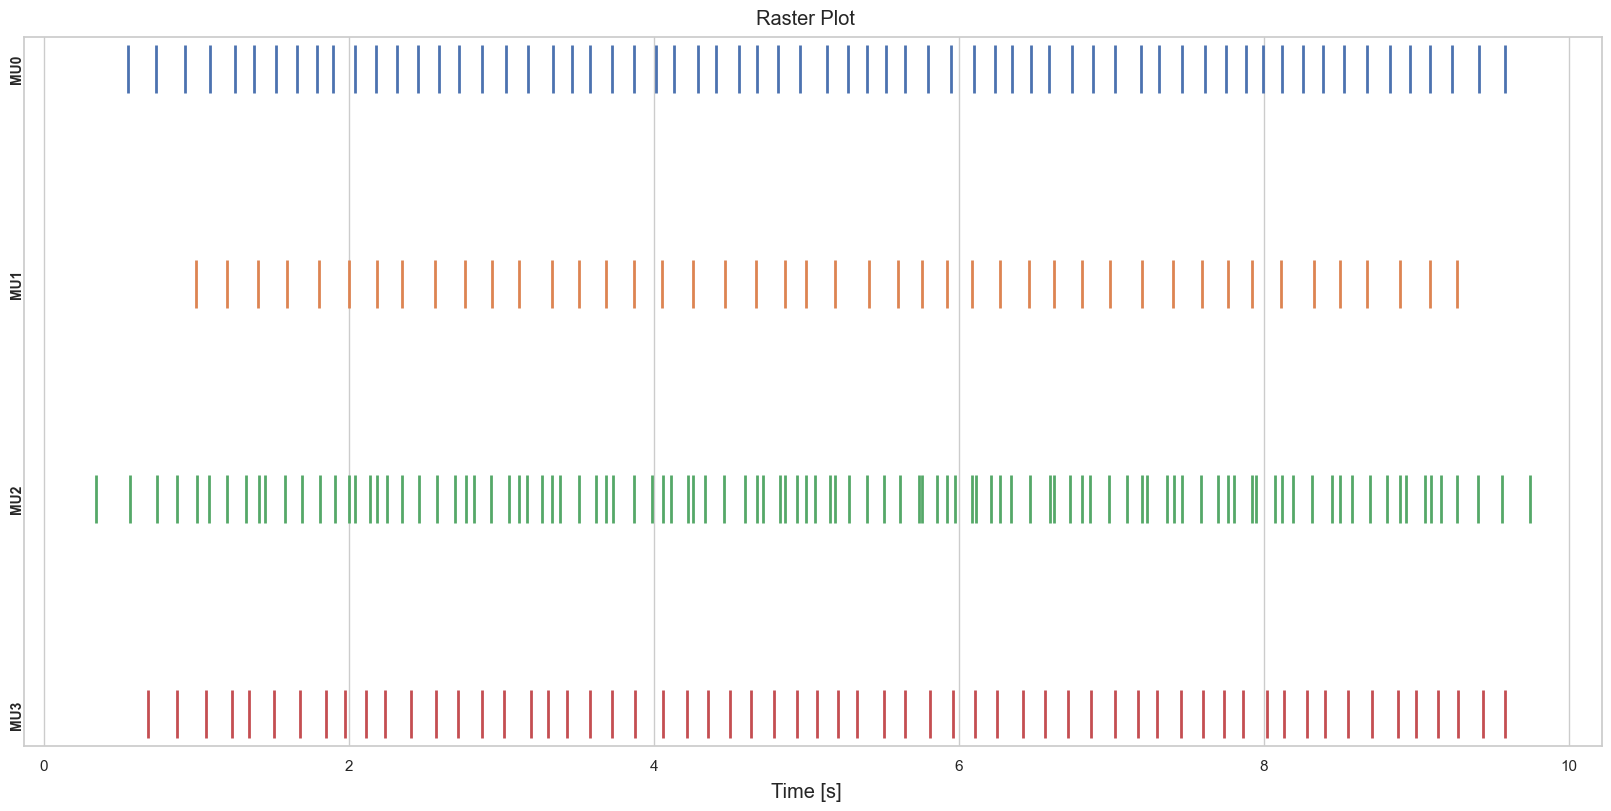

In [18]:
emgkit.plotting.raster_plot(spikes_t1, fig_size=(16, 8))

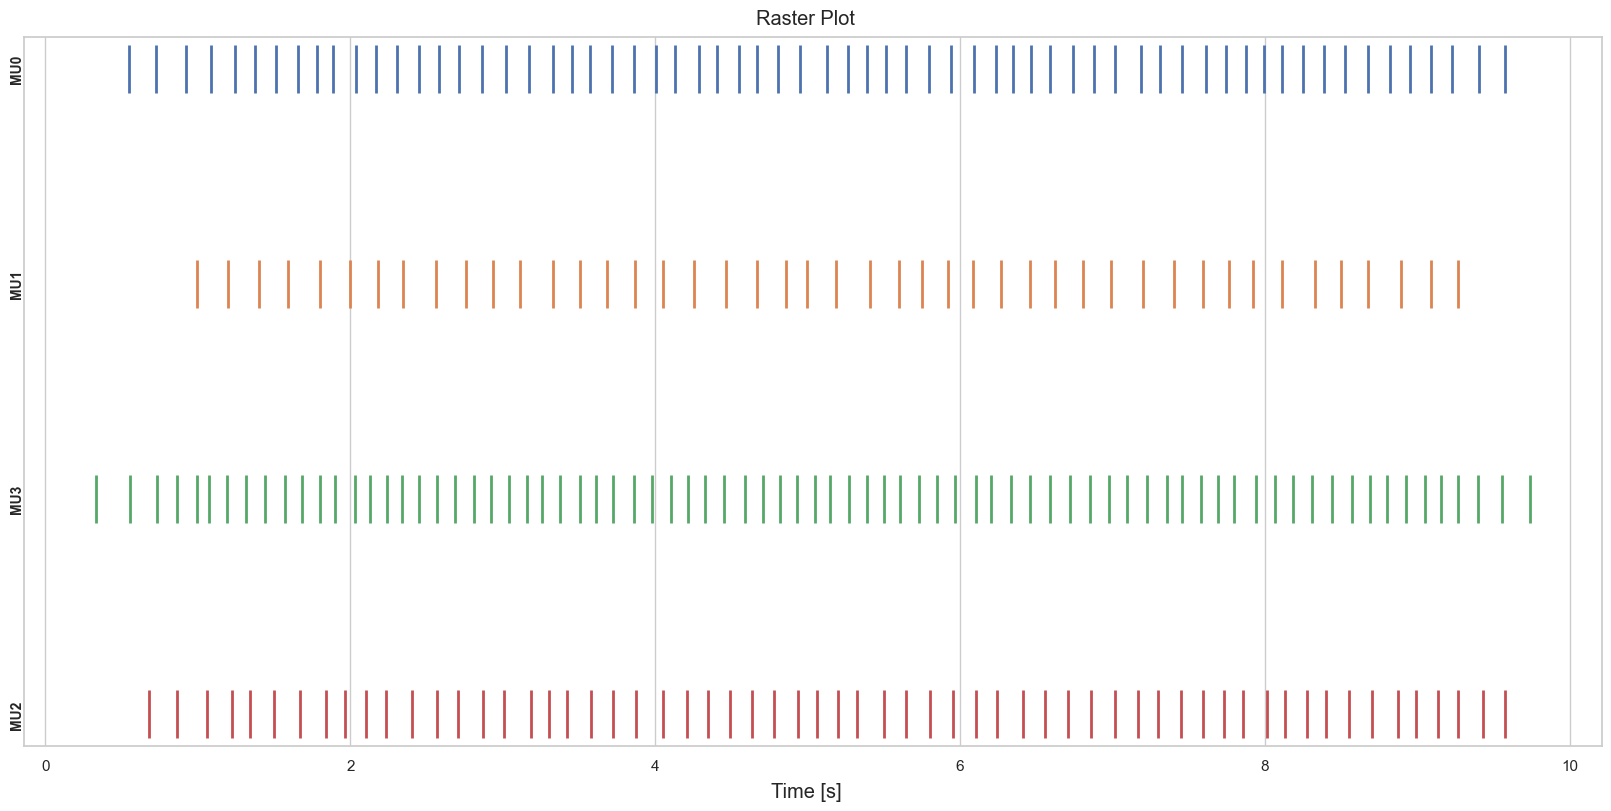

In [19]:
# 1. 获取 gt_spikes_t_tmp 中的 另一个Patch解耦获得的MU 的顺序
gt_order = list(spikes_t1.keys())

# 2. 创建一个新的字典，按 另一个Patch解耦获得的MU 的顺序重新排列 spikes_t
aligned_spikes_t = {}

# 遍历 gt_order，找到与其对应的 Estimated MU
for gt_mu in gt_order:
    # 根据 valid_mus 中的 ground truth MU 找到对应的 Estimated MU
    for est_mu, (mapped_gt_mu, _, _, _) in valid_mus.items():
        if mapped_gt_mu == gt_mu:
            # 将 Estimated MU 的 spike 数据按照 另一个Patch解耦获得的MU 的顺序进行排列
            aligned_spikes_t[est_mu] = spikes_t2[est_mu]
            break
emgkit.plotting.raster_plot(aligned_spikes_t, fig_size=(16, 8))